# Introduction
Investigation of bitcoin-focused reddit groups

### Standard Imports

In [227]:
# Basic functions
import os

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

### Specific Imports

In [3]:
import bz2, json
import psaw
from psaw import PushshiftAPI
from copy import deepcopy
import datetime as dt

In [4]:
from tqdm import tqdm_notebook as tqdm, trange

In [275]:
from social_media import *

ModuleNotFoundError: No module named 'social_media'

# Get Data

## Get Subreddits

In [5]:
raw_data_path = '../data/raw'
subreddit_file = 'subreddits_basic.csv'
subreddit_path = os.path.join(raw_data_path, subreddit_file)

In [6]:
def format_cols(df):
    df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
    return df

def lowercase_cols(df, cols):
    for col in cols:
        df[col] = df[col].str.lower()
    return df

def col_to_datetime(df, col, unit='s'):
    df[col] = pd.to_datetime(df[col], unit=unit)
    return df

def contains_str(df, col, _str, regex=True, match=False):
    col_fmt = df[col].fillna("").str
    if match:
        condition = col_fmt.match(_str)
    else:
        condition = col_fmt.contains(_str, regex=regex)
    df = df.loc[condition]
    return df

def isin_col(df, col, strings):
    str_list = [term.lower() for term in strings]
    condition = df[col].isin(str_list)
    return df.loc[condition]

### Subreddit Sample

In [7]:
subreddit_data = (
    pd.read_csv(subreddit_path)
    .pipe(format_cols)
    .rename(columns={'creation_epoch':'created', 'subreddit_name':'name', 'number_of_subscribers':'subscribers'})
    .pipe(lowercase_cols, ['name'])
    .pipe(col_to_datetime, 'created')
    .set_index('reddit_base36_id')
)

subreddit_data.head()

,base10_id,created,name,subscribers
reddit_base36_id,,,,
t5_vf2,40718.0,2006-01-19 19:49:21,nsfw,936786
t5_21n6,95442.0,2006-02-19 06:55:30,features,1396
t5_21nj,95455.0,2006-02-19 07:11:36,request,547
t5_21of,95487.0,2006-02-19 08:02:34,olympics,397323
t5_22i0,96552.0,2006-02-20 06:22:35,de,108579


In [8]:
def create_regex_filter(terms):
    filt = terms[0].lower()
    for term in terms:
        filt += '|' + term.lower() 
    return filt

In [9]:
sr_list = [
    'CryptoMarkets',
    'BitcoinMarkets',
    'CryptoCurrencyTrading',
    'ethtrader',
    'cryptotrading',
    'CryptoCurrency',
    'Bitcoin',
    'Ethereum',
    'BTC',
    'litecointraders',
]

In [10]:
filter_str = create_regex_filter(sr_list)
crypto_subreddits = (
    subreddit_data
    .pipe(isin_col, 'name', sr_list)
    .replace('None', 0)
    .dropna()
    .astype({'subscribers':int})
    .sort_values('subscribers', ascending=False)
    .head(30)
)

## Subreddit Responses

In [11]:
import datetime as dt
from dateutil.relativedelta import relativedelta

In [13]:
relativedelta(months=6, days=0)

relativedelta(months=+6)

In [15]:
str(dt.datetime(2019, 11, 2))

'2019-11-02 00:00:00'

## Get all Subreddit Data and Save to Disk

In [85]:
def get_start_end_date(months, days=0):
    end_date = dt.datetime.utcnow()
    start_date = end_date - relativedelta(months=months, days=days)
    return start_date, end_date

def format_date_str(dt):
    return dt.strftime('%d%b%Y')

def get_cache(subreddit, start_date, end_date):    
    api = PushshiftAPI()
    start_epoch=int(dt.datetime.timestamp(start_date))
    end_epoch=int(dt.datetime.timestamp(end_date))
    work = api.search_comments(
    #     q = "notch",
        subreddit = sr,
        after= start_epoch,
        before= end_epoch
    )
    cache = []
    for c in work:
        cache.append(c)
    
    return cache
        
def get_response_list(cache):
    response_list = []
    for i in trange(len(cache)):
        response_dict = cache[i].d_
        response_list.append(response_dict)
    
    return response_list
    
def get_response_df(response_list):
    keep_cols = [
        'author',
        'author_flair_text',
        'body',
        'created_utc',
        'is_submitter',
        'score',
        'no_follow',
        'id',
        'parent_id'   
    ]
    
    response_df = (
        pd.DataFrame(response_list)
        .filter(keep_cols)
        .pipe(lowercase_cols, ['body'])
#         .pipe(remove_stopwords, 'body')
#         .assign(body = lambda x: x['body'].apply(lambda x: _tokenize(x))) #tokenize

    #     .pipe(remove_punctuation, ['body'])
        .assign(created = lambda x: pd.to_datetime(x['created_utc'], unit='s'))
        .set_index('id')
    )
    
    return response_df

In [86]:
start_date, end_date = get_start_end_date(months=6, days=0)
start_str = format_date_str(start_date)
end_str = format_date_str(end_date)

print(f'Getting data from {start_str} to {end_str}..')

cache_dict = {}
for sr in tqdm(sr_list[:]):
    # Get Data
    cache = get_cache(sr, start_date, end_date)        
    response_list = get_response_list(cache)
    response_df = get_response_df(response_list)
    
    # Save Data
    filename = f'r_{sr} response data {start_str}-{end_str}.csv'
    save_path = os.path.join(raw_data_path, filename)
    response_df.to_csv(save_path)

Getting data from 09May2019 to 09Nov2019..


100%|████████████████████████████████████| 455/455 [00:00<00:00, 454382.93it/s]


# Exploratory Data Analysis

### NLTK Imports

In [50]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

## NLP Functions

In [196]:
import string

def remove_punctuation(df, col):
    punct = string.punctuation.replace('|', '') + '”' + '’'
    transtab = str.maketrans(dict.fromkeys(punct, ''))
    
    translated = (
        df[col]
        .str.translate(transtab)
        .replace('”|’', '', regex=True)
    )
    df[col] = translated
    return df

def _tokenize(x, remove_duplicates=True):
    tokenizer = RegexpTokenizer(r'\w+')
    raw_tokens = tokenizer.tokenize(x)
    tokens = set(raw_tokens) if remove_duplicates else raw_tokens
    return list(tokens)

def remove_stopwords2(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

def remove_stopwords(df, col):
    to_remove = stopwords.words('english')
    pat = r'\b(?:{})\b'.format('|'.join(to_remove))
    df[col] = df[col].str.replace(pat, '', regex=True)
    return df

## Responses Summary Statistics

In [130]:
def clean_responses(response_df):
    response_df = (
        response_df
        .query('body != "[removed]"')
    )
    return response_df

def calc_posts_per_day(response_df):
    posts_per_day = (
        response_df
        .groupby(pd.to_datetime(response_df['created']).dt.date)
        .count()
        .mean()
        ['body']
    )
    return posts_per_day

def calc_posts_per_parent(response_df):
    posts_per_parent = (
        response_df
        .groupby('parent_id')
        .count()
        .mean()
        ['body']
    )
    return posts_per_parent

def get_author_counts(response_df, thresh=6):
    author_counts = (
        response_df
        .query('author != "[deleted]"')['author']
        .value_counts()
        .pipe(lambda x: x[x>=thresh])
    )
    return author_counts

def get_author_counts_norm(response_df, thresh=6):
    author_counts = get_author_counts(response_df, thresh=thresh)
    return author_counts / author_counts.sum()

def hhi(array):
    return np.square(array).sum()

In [305]:
import ast

summary_df = pd.DataFrame()
total = 0
for sr in tqdm(sr_list[:]):
    filename = f'r_{sr} response data {start_str}-{end_str}.csv'
    save_path = os.path.join(raw_data_path, filename)
    print(save_path)
    response_df = (
        pd.read_csv(save_path, index_col=0)
        .pipe(clean_responses)
    )
    
    total += len(response_df)
    
    summary_stats = pd.Series({
        'Posts per Day':calc_posts_per_day(response_df),
        'Posts per Parent':calc_posts_per_parent(response_df),
        'Unique Authors':len(response_df['author'].drop_duplicates()),
        'HHI, Authors':hhi(get_author_counts_norm(response_df))
    })
    
    summary_df[sr] = summary_stats

../data/raw\r_CryptoMarkets response data 09May2019-09Nov2019.csv
../data/raw\r_BitcoinMarkets response data 09May2019-09Nov2019.csv
../data/raw\r_CryptoCurrencyTrading response data 09May2019-09Nov2019.csv
../data/raw\r_ethtrader response data 09May2019-09Nov2019.csv
../data/raw\r_cryptotrading response data 09May2019-09Nov2019.csv
../data/raw\r_CryptoCurrency response data 09May2019-09Nov2019.csv
../data/raw\r_Bitcoin response data 09May2019-09Nov2019.csv
../data/raw\r_Ethereum response data 09May2019-09Nov2019.csv
../data/raw\r_BTC response data 09May2019-09Nov2019.csv
../data/raw\r_litecointraders response data 09May2019-09Nov2019.csv



In [306]:
total

1647871

In [178]:
summary_df.T.to_csv('../data/interim/EDA.csv')

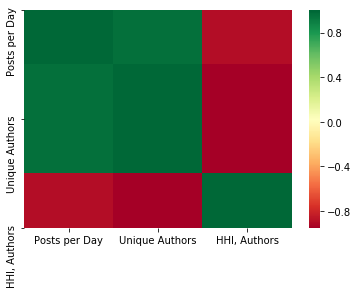

In [171]:
import seaborn as sns

sns.heatmap(summary_df.T.corr('spearman'), cmap='RdYlGn')

## Popular words

In [231]:
drop_words = [
    'also',
    'https',             
    'would',             
    'make',              
    'much',
    'get',
    'think',
    'one',
    'com',
    'like',
    'see',
    'really',
    'know',
    'still',
    'well',
    'could',
    'going',
    'way',
    'go',
    '1',
    'need',
    'gt',
    'many',
    'www',
    'want',
    'sure',
    '2',
    'r',
    'back',
    'thanks',
    'reddit',
    '0',
    'something',
    'actually',
    'next',
    'day',
    'say',
    'lol',
    '10',
    'take',
    'us',
    'days',
]

popular_words = pd.DataFrame()
for sr in tqdm(sr_list[:]):
    filename = f'r_{sr} response data {start_str}-{end_str}.csv'
    save_path = os.path.join(raw_data_path, filename)
    print(save_path)
    response_df = (
        pd.read_csv(save_path, index_col=0)
        .pipe(clean_responses)
        .dropna(subset=['body'])
        .pipe(remove_stopwords, 'body')
        .assign(body = lambda x: x['body'].apply(lambda x: _tokenize(x))) #tokenize
#         .pipe(remove_punctuation, 'body')
    )
    flattened = pd.Series([item for sublist in response_df['body'] for item in sublist])
    flattened = flattened[~flattened.isin(drop_words)]
    popular_words[sr] = flattened.value_counts()[:50].index

../data/raw\r_CryptoMarkets response data 09May2019-09Nov2019.csv
../data/raw\r_BitcoinMarkets response data 09May2019-09Nov2019.csv
../data/raw\r_CryptoCurrencyTrading response data 09May2019-09Nov2019.csv
../data/raw\r_ethtrader response data 09May2019-09Nov2019.csv
../data/raw\r_cryptotrading response data 09May2019-09Nov2019.csv
../data/raw\r_CryptoCurrency response data 09May2019-09Nov2019.csv
../data/raw\r_Bitcoin response data 09May2019-09Nov2019.csv
../data/raw\r_Ethereum response data 09May2019-09Nov2019.csv
../data/raw\r_BTC response data 09May2019-09Nov2019.csv
../data/raw\r_litecointraders response data 09May2019-09Nov2019.csv



In [251]:
def rename_index(df, name):
    df.index.name = name
    return df

In [255]:
popular_words.pipe(rename_index, 'rank').iloc[:20, 5:].to_csv('../data/interim/top_20_words_2.csv')

In [286]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import matplotlib as mpl

ref_path = '../references'
fig_path = '../reports/figures'
plt.style.use(os.path.join(ref_path, 'PaperDoubleFig.mplstyle'))
dashesStyles = [[3,1],
            [1000,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1]]

### Visualize Results

<BarContainer object of 20 artists>

Text(0.5, 0, '')

Text(0.5, 1.0, "Occurrences in Subreddits' Top 50")

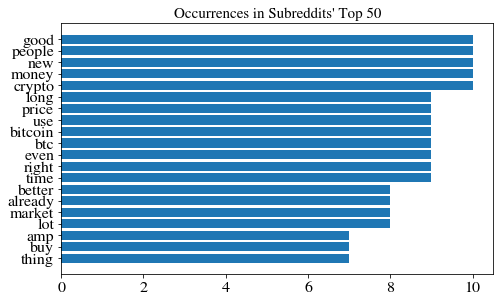

In [287]:
fig, ax = plt.subplots()
pop_word_counts = popular_words.melt()['value'].value_counts()[:20].sort_values()
ax.barh(pop_word_counts.index, pop_word_counts.values)
name_of_plot = 'Occurrences in Subreddits\' Top 50'
ax.set_xlabel('')
ax.yaxis.major.formatter._useMathText = True
# ax.yaxis.set_label_coords(0.63,1.01)

ax.set_title(name_of_plot, fontsize=15, rotation=0)

fig.tight_layout()
savefig_path = os.path.join(fig_path, name_of_plot)
fig.savefig(savefig_path,dpi=300)
plt.show()

In [217]:
popular_words

,CryptoMarkets,BitcoinMarkets,CryptoCurrencyTrading,ethtrader,cryptotrading,CryptoCurrency,Bitcoin,Ethereum,BTC,litecointraders
0,like,like,good,eth,project,like,bitcoin,like,bitcoin,think
1,crypto,bitcoin,crypto,like,curioinvest,bitcoin,like,ethereum,bch,ltc
2,people,btc,project,would,great,people,people,would,btc,btc
3,bitcoin,think,like,think,platform,https,would,https,gt,like
4,one,time,https,people,com,btc,https,eth,like,market
...,...,...,...,...,...,...,...,...,...,...
45,exchange,point,much,www,everyone,contact,market,sure,2,year
46,better,since,system,sure,opportunity,automatically,say,network,many,drop
47,many,got,users,years,think,concerns,many,bitcoin,using,make
48,sure,day,already,take,users,1,reddit,better,go,prices


# Sentiment Analysis

## User-defined list of words

In [278]:
def isin_col(df, col, strings):
    str_list = [term.lower() for term in strings]
    p = r"\b(?:{})\b".format("|".join(map(re.escape, strings)))
    condition = df[col].str.contains(p)
    return df.loc[condition]


In [282]:
bull_words = [
    'buy',
    'bullish',
    'bull',
    'long',
    'pump',
    'moon',
    'fomo',
    'bid',
]

bear_words = [
    'sell',
    'bear',
    'bearish',
    'short',
    'dump',
    'nuke',
    'nook',
    'doom',
    'fud',
    'puke',
]

sentiment_words = pd.DataFrame()
for sr in tqdm(sr_list[:]):
    filename = f'r_{sr} response data {start_str}-{end_str}.csv'
    save_path = os.path.join(raw_data_path, filename)
    print(save_path)
    response_df = (
        pd.read_csv(save_path, index_col=0)
        .pipe(clean_responses)
        .dropna(subset=['body'])
    )
    
    bull_df = response_df.pipe(isin_col, 'body', bull_words)
    bull_perc = len(bull_df) / len(response_df)    
    
    bear_df = response_df.pipe(isin_col, 'body', bear_words)
    bear_perc = len(bear_df) / len(response_df)
    
    sentiment_words[sr] = pd.Series({'Bull %':bull_perc, 'Bear %':bear_perc})

../data/raw\r_CryptoMarkets response data 09May2019-09Nov2019.csv
../data/raw\r_BitcoinMarkets response data 09May2019-09Nov2019.csv
../data/raw\r_CryptoCurrencyTrading response data 09May2019-09Nov2019.csv
../data/raw\r_ethtrader response data 09May2019-09Nov2019.csv
../data/raw\r_cryptotrading response data 09May2019-09Nov2019.csv
../data/raw\r_CryptoCurrency response data 09May2019-09Nov2019.csv
../data/raw\r_Bitcoin response data 09May2019-09Nov2019.csv
../data/raw\r_Ethereum response data 09May2019-09Nov2019.csv
../data/raw\r_BTC response data 09May2019-09Nov2019.csv
../data/raw\r_litecointraders response data 09May2019-09Nov2019.csv



In [300]:
# sentiment_words = sentiment_words.T
sentiment_words['Difference'] = np.log(sentiment_words['Bull %']) - np.log(sentiment_words['Bear %'])
sentiment_words.sort_values('Difference', inplace=True)

In [301]:
sentiment_words

,Bull %,Bear %,Difference
litecointraders,0.292079,0.215347,0.304777
BitcoinMarkets,0.154484,0.110521,0.334889
CryptoMarkets,0.073852,0.039664,0.621629
CryptoCurrency,0.088425,0.045192,0.671246
ethtrader,0.093228,0.045377,0.720034
Ethereum,0.049642,0.023802,0.735094
Bitcoin,0.092883,0.041833,0.797647
BTC,0.051465,0.023099,0.801104
CryptoCurrencyTrading,0.077436,0.031405,0.902497
cryptotrading,0.069530,0.020450,1.223775


### Visualize Results

Text(0.5, 0, '')

[Text(0, 0, 'litecointraders'),
 Text(0, 0, 'BitcoinMarkets'),
 Text(0, 0, 'CryptoMarkets'),
 Text(0, 0, 'CryptoCurrency'),
 Text(0, 0, 'ethtrader'),
 Text(0, 0, 'Ethereum'),
 Text(0, 0, 'Bitcoin'),
 Text(0, 0, 'BTC'),
 Text(0, 0, 'CryptoCurrencyTrading'),
 Text(0, 0, 'cryptotrading')]

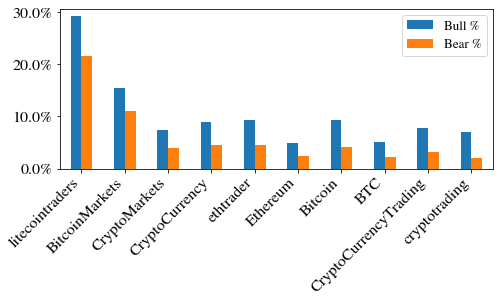

In [304]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots()

sentiment_words.iloc[:, :2].plot(kind='bar', ax=ax)
name_of_plot = 'bull_bear_by_subreddit'
ax.set_xlabel('')
ax.set_xticklabels(sentiment_words.index, rotation = 45, ha="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.major.formatter._useMathText = True
# ax.yaxis.set_label_coords(0.63,1.01)

# ax.set_title(name_of_plot, fontsize=15, rotation=0)

fig.tight_layout()
savefig_path = os.path.join(fig_path, name_of_plot+'.pdf')
fig.savefig(savefig_path, dpi=300)
plt.show()

## Correlation with Price

In [ ]:
sentiment_words = pd.DataFrame()
for sr in tqdm(sr_list[:]):
    filename = f'r_{sr} response data {start_str}-{end_str}.csv'
    save_path = os.path.join(raw_data_path, filename)
    print(save_path)
    response_df = (
        pd.read_csv(save_path, index_col=0)
        .pipe(clean_responses)
        .dropna(subset=['body'])
    )
    
    bull_df = response_df.pipe(isin_col, 'body', bull_words)
    bull_perc = len(bull_df) / len(response_df)    
    
    bear_df = response_df.pipe(isin_col, 'body', bear_words)
    bear_perc = len(bear_df) / len(response_df)
    
    sentiment_words[sr] = pd.Series({'Bull %':bull_perc, 'Bear %':bear_perc})